# License

Copyright (c) 2024 Pranjal Choudhury, Bosanta Ranjan Boruah

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License
as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see <http://www.gnu.org/licenses/>.

######################################################################################################################################


# 

This code is prepared based on Deep-STORM and ZeroCostDL4Mic platform. Please also cite their work.

This file contains the CNN model which is to be trained. Please load the correct files and run the cells below

# Dependencies

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, UpSampling2D, Convolution2D, MaxPooling2D, BatchNormalization, Layer, Add
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from scipy.ndimage import gaussian_filter

import os
import numpy as np
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import shutil
import csv
import time




# Basic Functionalities

In [111]:
# project image in floating point values between 0 and 1
def project_01(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val)

# normalize image given mean and std
def normalize_im(im, dmean, dstd):
    im = np.squeeze(im)
    im_norm = np.zeros(im.shape,dtype=np.float32)
    im_norm = (im - dmean)/dstd
    return im_norm

# Define the loss history recorder
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Loss Function

In [44]:
# prepare a 2D gaussian 
def matlab_style_gauss2D(shape=(7,7),sigma=1):

    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h.astype(dtype=K.floatx())
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h.astype('float32')
    return h

# Expand the filter dimensions
psf_heatmap = matlab_style_gauss2D(shape = (7,7),sigma=1)
#psf_heatmap = matlab_style_gauss2D(shape = (7,7),sigma=0.35)
gfilter = tf.reshape(psf_heatmap, [7, 7, 1, 1])

# The loss function
def loss_function(input_shape, norm_ai, weight):

    def bump_mse(heatmap_true, spikes_pred):

        # generate the heatmap corresponding to the predicted spikes
        heatmap_pred = K.conv2d(spikes_pred, gfilter, strides=(1, 1), padding='same')
        
        # heatmaps MSE
        loss_heatmaps = losses.mean_squared_error(heatmap_true,heatmap_pred)
        
        return loss_heatmaps 
    return bump_mse

def compute_norm_ai(input_dim, upsampling_factor, psf_heatmap):
    norm_ai = np.ones((input_dim[0], input_dim[1]), dtype=np.float32)
    matr = np.linalg.norm(psf_heatmap)

    return matr*norm_ai

# The network

In [112]:
# The convolutional block
def conv_bn_relu(nb_filter, rk, ck, name):
    def f(input):
        conv = Convolution2D(nb_filter, kernel_size=(rk, ck), strides=(1,1),\
                               padding="same", use_bias=False,\
                               kernel_initializer="Orthogonal",name='conv-'+name)(input)
        conv_norm = BatchNormalization(name='BN-'+name)(conv)
        conv_norm_relu = Activation(activation = "relu",name='Relu-'+name)(conv_norm)
        return conv_norm_relu
    return f

# The residual block
def residual_block(input_features, nb_filter, rk, ck, name):
    conv1 = conv_bn_relu(nb_filter, rk, ck, name + '_conv1')(input_features)
    conv2 = conv_bn_relu(nb_filter, rk, ck, name + '_conv2')(conv1)
    shortcut = Convolution2D(nb_filter, (1, 1), strides=(1, 1), padding='same')(input_features)
    output = Add()([conv2, shortcut])
    return output

# Define the model architecture
def CNN_with_residue(input, names):
    Features1 = conv_bn_relu(32, 3, 3, names+'F1')(input)
    # pool1 = MaxPooling2D(pool_size=(2, 2), name= names+'Pool1')(Features1)
    Features2 = residual_block(Features1, 64, 3, 3, names+'Res1')
    # pool2 = MaxPooling2D(pool_size=(2, 2), name=names+'Pool2')(Features2)

    Features3 = conv_bn_relu(128, 3, 3, names+'F3')(Features2)
    up1 = UpSampling2D(size=(2, 2), name = names+ 'Up1')(Features3)
    Features4 = conv_bn_relu(64, 3, 3, names+'F4')(up1)
    up2 = UpSampling2D(size=(2, 2),name = names+ 'Up3')(Features4)
    return up2


# Define the Model building for an arbitrary input size
def buildModel(input_dim, initial_learning_rate = 0.001, L0_weight = 1):
    input_ = Input (shape = (input_dim))
    act_ = CNN_with_residue (input_,'CNN')
    density_pred = Convolution2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",\
                                  activation="relu", use_bias = False,\
                                  kernel_initializer="Orthogonal",name='Prediction')(act_)
    model = Model (inputs= input_, outputs=density_pred)
    opt = optimizers.Adam(learning_rate = initial_learning_rate)
    norm_ai = compute_norm_ai(input_dim, 1, psf_heatmap)
    model.compile(optimizer=opt, loss = loss_function(input_dim, norm_ai, L0_weight))
    return model


## data preprocessing and training function

In [5]:
# define a function that trains a model for a given data SNR and density
def train_model(patches, heatmaps, modelPath, epochs, batch_size, 
                validation_split = 0.2, initial_learning_rate = 0.001, 
                L2_weighting_factor = 100, L0_weight = 1):
    
    
    # for reproducibility
    np.random.seed(123)

    X_train, X_test, y_train, y_test = train_test_split(patches, heatmaps, test_size = validation_split, random_state=42)
    print('Number of training examples: %d' % X_train.shape[0])
    print('Number of validation examples: %d' % X_test.shape[0])
       
    # Setting type
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    
    #===================== Training set normalization ==========================
    # normalize training images to be in the range [0,1] and calculate the 
    # training set mean and std
    mean_train = np.zeros(X_train.shape[0],dtype=np.float32)
    std_train = np.zeros(X_train.shape[0], dtype=np.float32)
    for i in range(X_train.shape[0]):
        X_train[i, :, :] = project_01(X_train[i, :, :])
        mean_train[i] = X_train[i, :, :].mean()
        std_train[i] = X_train[i, :, :].std()

    # resulting normalized training images
    mean_val_train = mean_train.mean()
    std_val_train = std_train.mean()
    X_train_norm = np.zeros(X_train.shape, dtype=np.float32)
    for i in range(X_train.shape[0]):
        X_train_norm[i, :, :] = normalize_im(X_train[i, :, :], mean_val_train, std_val_train)
    
    # patch size
    psize = X_train_norm.shape[1]

    # Reshaping
    X_train_norm = X_train_norm.reshape(X_train.shape[0], psize, psize, 1)

    # ===================== Test set normalization ==========================
    # normalize test images to be in the range [0,1] and calculate the test set 
    # mean and std
    mean_test = np.zeros(X_test.shape[0],dtype=np.float32)
    std_test = np.zeros(X_test.shape[0], dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test[i, :, :] = project_01(X_test[i, :, :])
        mean_test[i] = X_test[i, :, :].mean()
        std_test[i] = X_test[i, :, :].std()

    # resulting normalized test images
    mean_val_test = mean_test.mean()
    std_val_test = std_test.mean()

    X_test_norm = np.zeros(X_test.shape, dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test_norm[i, :, :] = normalize_im(X_test[i, :, :], mean_val_test, std_val_test)
        
    # Reshaping
    X_test_norm = X_test_norm.reshape(X_test.shape[0], psize, psize, 1)

    # Reshaping labels
    psize_test = y_train.shape[1]
    Y_train = y_train.reshape(y_train.shape[0], psize_test, psize_test, 1)
    Y_test = y_test.reshape(y_test.shape[0], psize_test, psize_test, 1)

    # Save datasets to a matfile to open later in matlab
    mdict = {"mean_test": mean_val_test, "std_test": std_val_test, 
              "Normalization factor": L2_weighting_factor}
    sio.savemat(os.path.join(modelPath,"model_metadata.mat"), mdict)


    # Set the dimensions ordering according to tensorflow consensous
    # K.set_image_dim_ordering('tf')
    K.set_image_data_format('channels_last')

    # Save the model weights after each epoch if the validation loss decreased
    checkpointer = ModelCheckpoint(filepath=os.path.join(modelPath,"weights_best.hdf5"), verbose=1,
                                   save_best_only=True)

    # Change learning when loss reaches a plataeu
    change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00005)
    
    # Model building and complitation
    model = buildModel((psize, psize, 1), initial_learning_rate = initial_learning_rate, L0_weight = L0_weight)
    model.summary()


    
    # Create an image data generator for real time data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0.,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
        zoom_range=0.,
        shear_range=0.,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='constant',
        data_format=K.image_data_format())

    # Fit the image generator on the training data
    datagen.fit(X_train_norm)
    
    # loss history recorder
    history = LossHistory()

    # Inform user training begun
    print('-------------------------------')
    print('Training model...')

    # Fit model on the batches generated by datagen.flow()
    train_history = model.fit(datagen.flow(X_train_norm, Y_train, batch_size=batch_size), 
                                        epochs=epochs, verbose=1, 
                                        validation_data=(X_test_norm, Y_test), 
                                        callbacks=[history, checkpointer, change_lr])    

    # Inform user training ended
    print('-------------------------------')
    print('Training Complete!')
    
    # Save the last model
    model.save(os.path.join(modelPath, 'weights_last.hdf5'))

    # convert the history.history dict to a pandas DataFrame:     
    lossData = pd.DataFrame(train_history.history) 

    if os.path.exists(os.path.join(modelPath,"Quality Control")):
      shutil.rmtree(os.path.join(modelPath,"Quality Control"))

    os.makedirs(os.path.join(modelPath,"Quality Control"))

    # The training evaluation.csv is saved (overwrites the Files if needed). 
    lossDataCSVpath = os.path.join(modelPath,"Quality Control/training_evaluation.csv")
    with open(lossDataCSVpath, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(['loss','val_loss','learning rate'])
      for i in range(len(train_history.history['loss'])):
        writer.writerow([train_history.history['loss'][i], train_history.history['val_loss'][i], train_history.history['lr'][i]])

    return


# Training

## Training parameters

In [6]:
Save_path = 'model'
patches = io.imread('data/training_images.tif')
heatmaps = io.imread('data/heatmaps.tif')

number_of_epochs = 30
batch_size = 16
percentage_validation = 0.2
initial_learning_rate = 0.001

L2_weighting_factor = 100
L0_weight = 1

## Training

In [7]:
##Start training

# Start the clock to measure how long it takes
start = time.time()

#here we check that no model with the same name already exist, if so delete
if os.path.exists(Save_path):
  shutil.rmtree(Save_path)

# Create the model folder!
os.makedirs(Save_path)

# Let's go !
train_model(patches, heatmaps, Save_path, 
            epochs=number_of_epochs, batch_size=batch_size,
            validation_split = percentage_validation,
            initial_learning_rate = initial_learning_rate, 
            L2_weighting_factor = L2_weighting_factor,
            L0_weight = L0_weight)



# Displaying the time elapsed for training
dt = time.time() - start
minutes, seconds = divmod(dt, 60) 
hours, minutes = divmod(minutes, 60) 
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds),"sec(s)")




Number of training examples: 8000
Number of validation examples: 2000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv-CNNF1 (Conv2D)            (None, 32, 32, 32)   288         ['input_1[0][0]']                
                                                                                                  
 BN-CNNF1 (BatchNormalization)  (None, 32, 32, 32)   128         ['conv-CNNF1[0][0]']             
                                                                                                  
 Relu-CNNF1 (Activation)        (None, 32, 32, 32)   0           ['BN-CNNF1[0][0]']               
                        

## loss evaluation

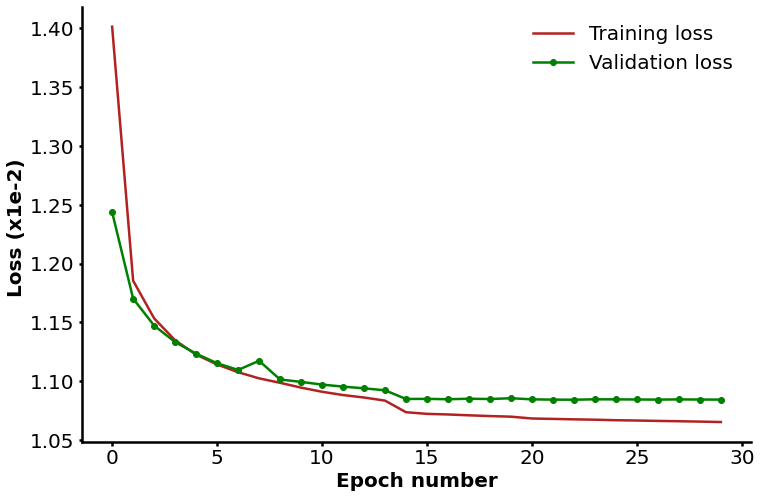

In [143]:
lossDataFromCSV = []
vallossDataFromCSV = []

csv_ = pd.read_csv('model/Quality Control/training_evaluation.csv')   # the csv  file that records the training loss 



fig,ax= plt.subplots(1,1, figsize=(12,8))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)

ax.plot(csv_['loss'], label='Training loss',  linewidth=2.5, color = 'firebrick')
ax.plot(csv_['val_loss'], label='Validation loss',  linewidth=2.5, color = 'green', marker = 'o')


ax.set_xlabel('Epoch number', fontsize=20, weight = 'bold')
ax.set_ylabel('Loss (x1e-2) ', fontsize=20, weight = 'bold')
ax.legend(loc='upper right', ncol=1, fontsize=20, frameon = False)
ax.tick_params(axis='both', labelsize=20, width = 2.5)



plt.savefig('model/Quality Control/lossCurvePlot.png', bbox_inches='tight', pad_inches=0)
plt.show()


# Validation of the model prediction

Create validation datasets using '01_training_data_generation..ipynb' and check the output of the CNN

In [ ]:
def process_test_images(images_):

    X_test = images_.astype('float32')
    #===================== Training set normalization ==========================
    # normalize training images to be in the range [0,1] and calculate the 
    # training set mean and std
    mean_test = np.zeros(X_test.shape[0],dtype=np.float32)
    std_test = np.zeros(X_test.shape[0], dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test[i, :, :] = project_01(X_test[i, :, :])
        mean_test[i] = X_test[i, :, :].mean()
        std_test[i] = X_test[i, :, :].std()

    # resulting normalized training images
    mean_val_test = mean_test.mean()
    std_val_test = std_test.mean()
    X_test_norm = np.zeros(X_test.shape, dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test_norm[i, :, :] = normalize_im(X_test[i, :, :], mean_val_test, std_val_test)

    # patch size
    psize = X_test_norm.shape[1]

    # Reshaping
    X_test_norm = X_test_norm.reshape(X_test.shape[0], psize, psize, 1)

    return X_test_norm

* load the validation images

In [ ]:
validation_image_in = io.imread('data/validation_input.tif')            #the input images
validation_image_in_norm = process_test_images(validation_image_in)
validation_image_out = io.imread('data/validation_output.tif')          #the actual output images


* run the cells below

In [ ]:
model = buildModel((32,32,1))
model.load_weights('model/weights_best.hdf5')

In [ ]:
validation_image_predict = model.predict(validation_image_in_norm)

In [ ]:
image_number = 10

fig,ax = plt.subplots(1,3, figsize = (18,6))

ax[0].imshow(validation_image_in[image_number], cmap = gray)
ax[1].imshow(validation_image_out[image_number], cmap = gray)
ax[2].imshow(validation_image_predict[image_number], cmap = gray)

ax[0].set_title('input image')
ax[1].set_title('output image (actual)')
ax[2].set_title('output image (predicted)')

plt.tight_layout()
plt.show()